In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy
from matplotlib import cm, pyplot
import fastprogress

import models
import plotting
import calibr8

In [5]:
cm_linear = models.get_glucose_model_linear()
cm_logistic = models.get_glucose_model()
cm_biomass = models.get_biomass_model()

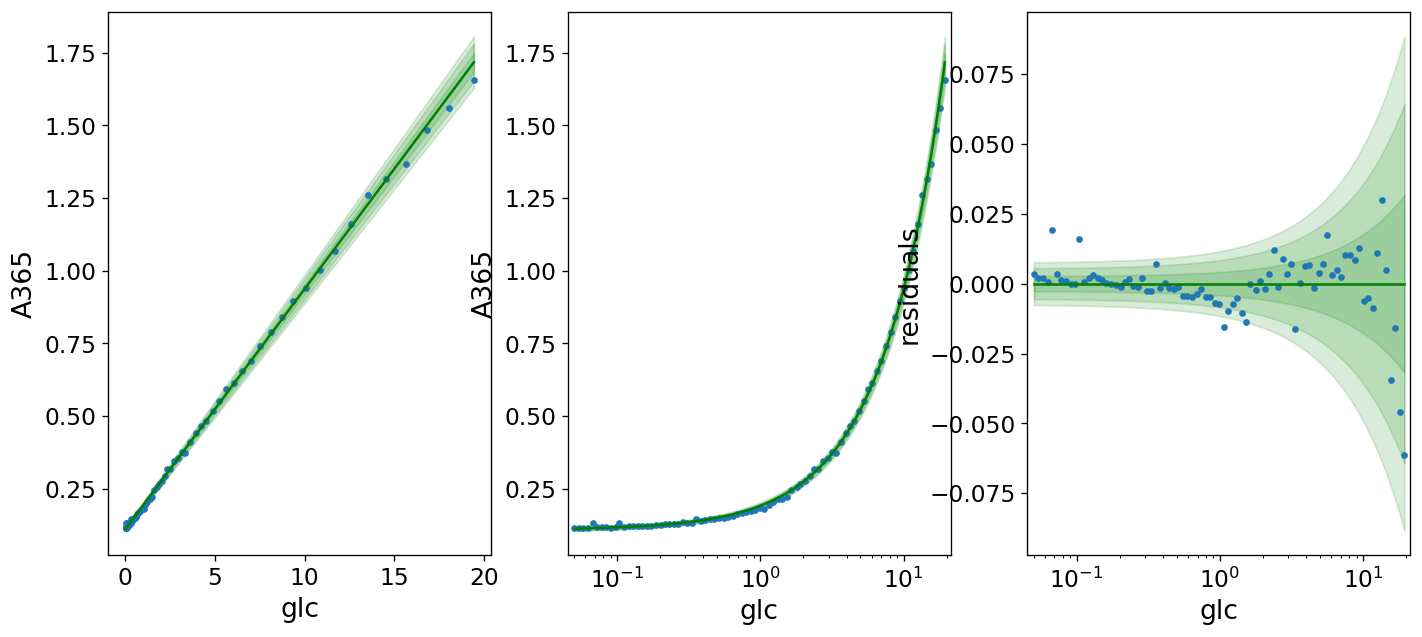

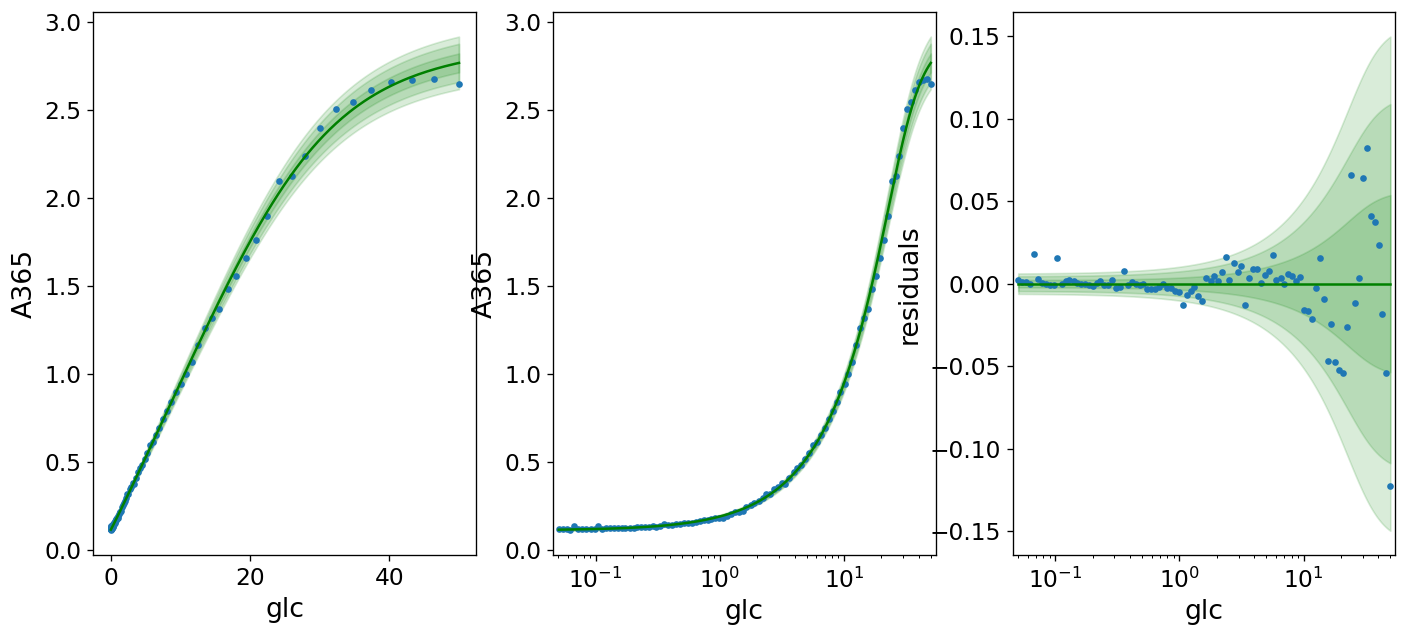

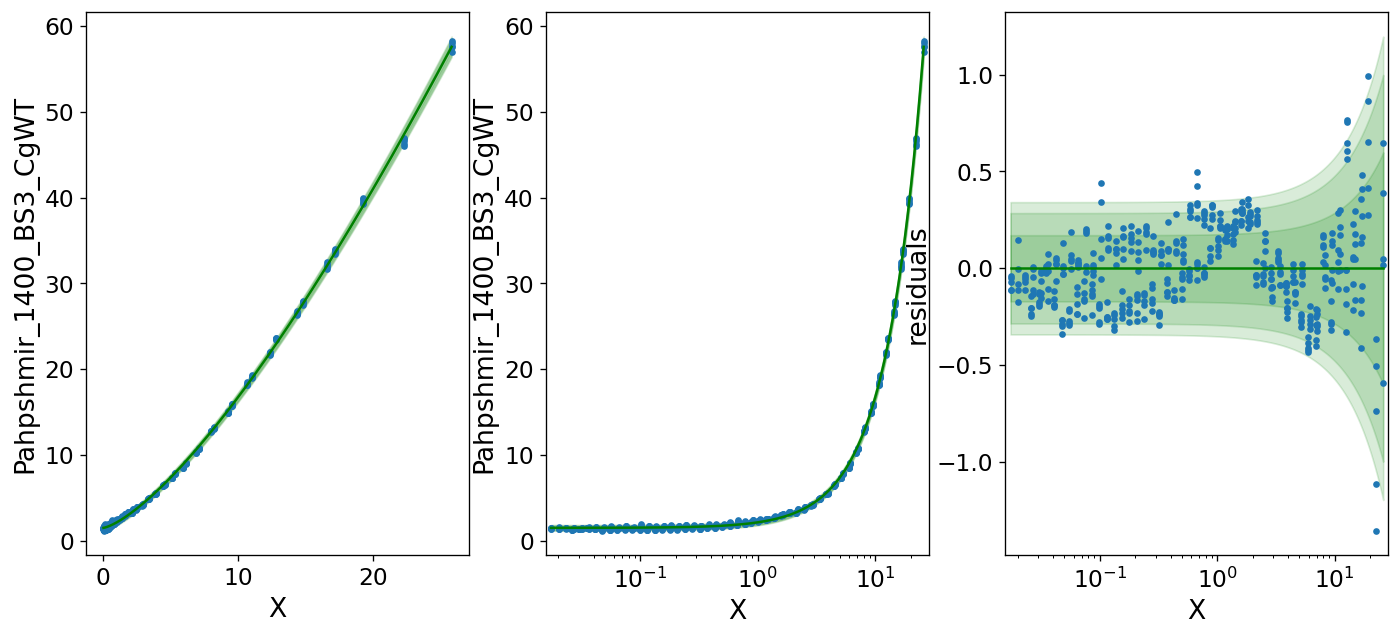

In [7]:
calibr8.plot_model(cm_linear);
calibr8.plot_model(cm_logistic);
calibr8.plot_model(cm_biomass);

In [1]:
def plot_infer_uncertainty(cm, xmax, xlabel):
    S = 10000
    #x_dense = numpy.exp(numpy.linspace(
    #    numpy.log(cm.cal_independent.min()),
    #    numpy.log(cm.cal_independent.max()),
    #    100
    #))
    x_dense = numpy.linspace(
        cm.cal_independent.min(),
        cm.cal_independent.max(),
        100
    )
    pdfs = numpy.zeros((100, S))
    xs = numpy.zeros_like(pdfs)
    for i, x in enumerate(fastprogress.progress_bar(x_dense)):
        y_obs = cm.predict_dependent(x)[0]
        pst = cm.infer_independent(y_obs, lower=0, upper=xmax, hdi_prob=0.9999, steps=S)
        pdfs[i, :] = pst.pdf
        xs[i, :] = pst.x_dense
    cdfs = numpy.cumsum(pdfs, axis=1)
    cdfs /= cdfs.max(axis=1)[:, None]

    fig, ax = pyplot.subplots(
        dpi=140, figsize=(6,6),
    )
    labels = []
    for err in [2, 5, 10, 20, 40]:
        p_lower = err / 100
        p_upper = 1 - p_lower
        i_lower = numpy.argmax(cdfs >= p_lower, axis=1)
        i_upper = numpy.argmax(cdfs >= p_upper, axis=1)
        # concentrations corresponding to lower/upper ETI
        x_lower = xs[numpy.arange(xs.shape[0]), i_lower]
        x_upper = xs[numpy.arange(xs.shape[0]), i_upper]
        # relative to the truth
        r_lower = 100 * (x_lower - x_dense) / x_dense
        r_upper = 100 * (x_upper - x_dense) / x_dense
        ax.fill_between(
            x_dense,
            r_lower,
            r_upper,
            color="blue",
            alpha=0.1
        )
        i = numpy.argmax(x_dense >= xlabel)
        y = r_upper[i]
        labels.append((f"{(100-2*err)} % ETI", xlabel, y))
    for l in range(len(labels)):
        label, x, y1 = labels[l]
        if l < len(labels) - 1:
            y2 = labels[l+1][-1]
            y = (y1 + y2) / 2
        else:
            y = 0
        ax.text(
            x, y,
            label,
            fontsize=10,
            verticalalignment="center",
            horizontalalignment="center",
        )
        
    # overlay the calibration data
    ax.scatter(
    cm.cal_independent,
        [
            100 * (cm.infer_independent(yobs, lower=0, upper=xmax).median - xobs) / xobs
            for yobs, xobs in zip(cm.cal_dependent, cm.cal_independent)
        ]
    )        
        
    #ax.plot(x_dense, numpy.zeros_like(x_dense), color="black", lw=0.5, ls="--")
    ax.set_ylim(-20, 20)
    ax.set_xlabel("glucose concentration [g/L]")
    ax.set_ylabel("rel. concentration [%]")
    ax.legend(handles=[
        ax.fill_between([], [], color="blue", label="$p(x \mid y_{obs}=\mathbf{E}_{dependent})$"),
        ax.scatter([], [], color="blue", label="calibration data")
    ])
    return fig, ax

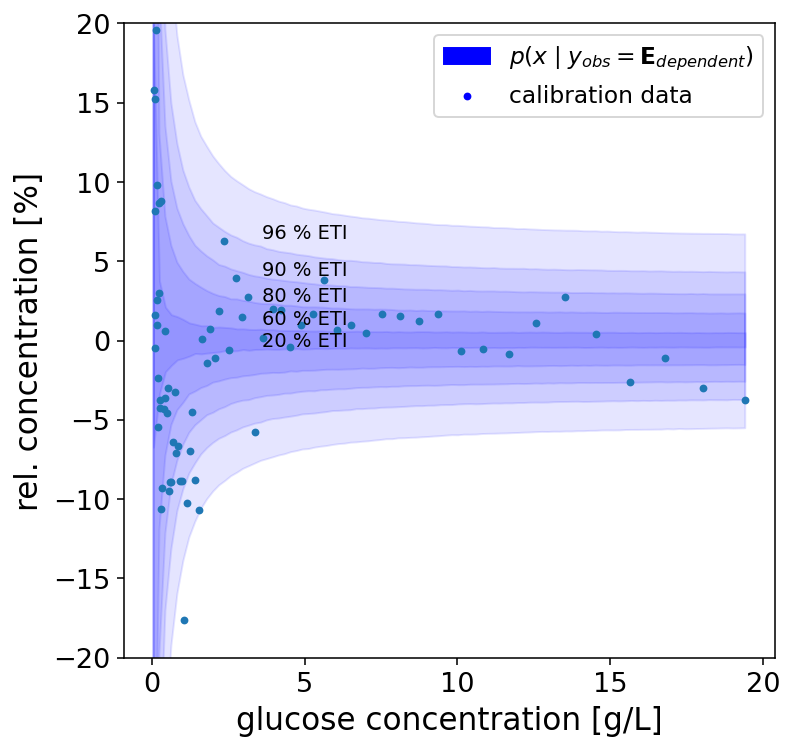

In [50]:
plot_infer_uncertainty(cm_linear, xmax=100, xlabel=5);

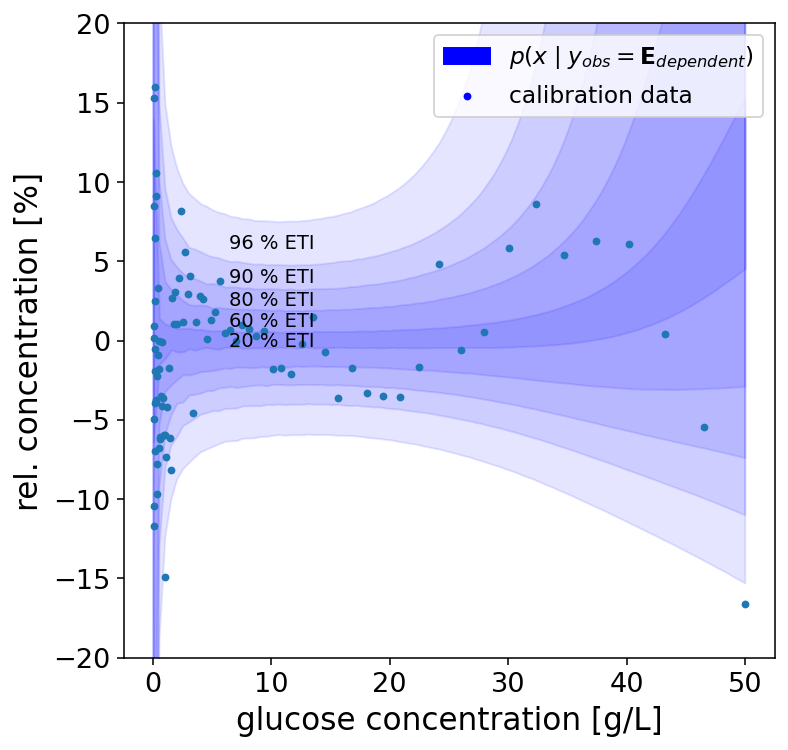

In [51]:
fig, ax = plot_infer_uncertainty(cm_logistic, xmax=100, xlabel=10)
pyplot.show()

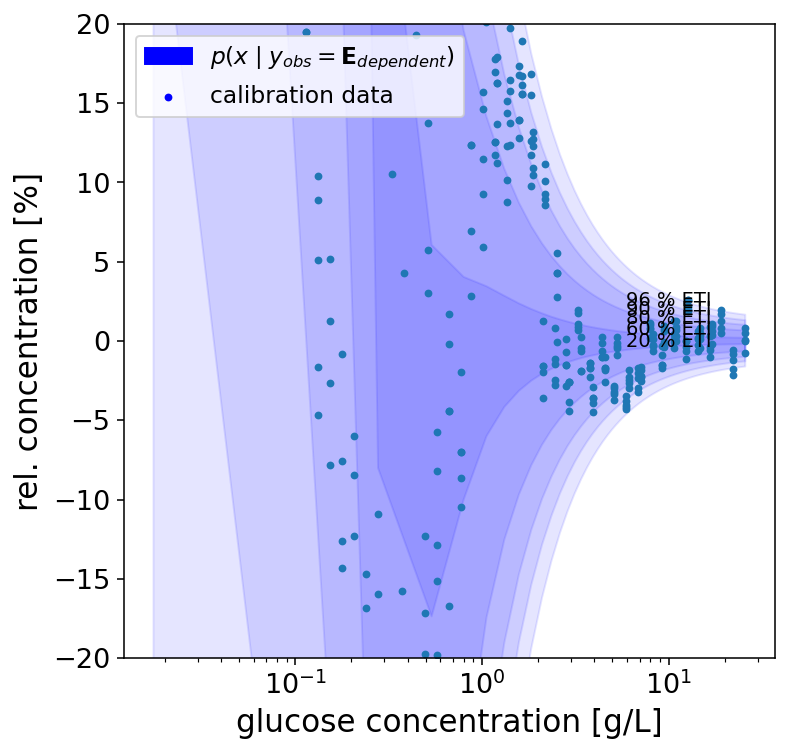

In [11]:
fig, ax = plot_infer_uncertainty(cm_biomass, xmax=100, xlabel=10)
ax.set_xscale("log")
pyplot.show()